<!-- loaded the Kaggle News Category Dataset from your local path:
C:\Users\bbuser\Desktop\News_Category_Dataset_v3.json

The dataset is in JSON Lines format (.json where each line = one record), so we used:

pd.read_json(DATA_PATH, lines=True) -->

##### 1) Loading the dataset

##### I used the Kaggle News Category Dataset from my local machine (News_Category_Dataset_v3.json).

##### Since the file is in JSON-Lines format, I loaded it with the correct setting to read each line as a separate record.

In [1]:
import os
import re
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS 
from wordcloud import WordCloud

DATA_PATH = r"C:\Users\bbuser\Desktop\News_Category_Dataset_v3.json"
OUTPUT_DIR = r"C:\Users\bbuser\Desktop\news_keyword_baseline"
os.makedirs(OUTPUT_DIR, exist_ok=True)

TARGET_CATEGORIES = ["POLITICS", "TRAVEL", "SPORTS", "HOME & LIVING"]
SAMPLES_PER_CLASS = 1000
TEST_SIZE = 0.20
RANDOM_STATE = 42

In [2]:
df = pd.read_json(DATA_PATH, lines=True)
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


##### The dataset originally contains multiple fields such as headline, authors, and link.

##### For this project, I only need the text description and the label, so I kept only the columns:

##### short_description (the input text)

##### category (the target label)

In [3]:
df = df[["short_description", "category"]].copy()

df = df.dropna(subset=["short_description"])
df["short_description"] = df["short_description"].astype(str).str.strip()
df = df[df["short_description"] != ""]

df.head()

,short_description,category
0,Health experts said it is too early to predict...,U.S. NEWS
1,He was subdued by passengers and crew when he ...,U.S. NEWS
2,"""Until you have a dog you don't understand wha...",COMEDY
3,"""Accidentally put grown-up toothpaste on my to...",PARENTING
4,Amy Cooper accused investment firm Franklin Te...,U.S. NEWS


##### I removed rows with missing or empty short descriptions.

##### I also ensured the descriptions were stored as clean strings without unnecessary spaces.

##### Filtering categories

##### The dataset covers more than 40 categories.

##### I restricted it to the four categories required for the task: POLITICS, TRAVEL, SPORTS, and HOME & LIVING.

In [4]:
df = df[df["category"].isin(TARGET_CATEGORIES)].copy()

print("Counts per category BEFORE balancing:")
print(df["category"].value_counts())

Counts per category BEFORE balancing:
category
POLITICS         32441
TRAVEL            9421
SPORTS            4414
HOME & LIVING     4317
Name: count, dtype: int64


##### Balancing the dataset

##### To keep the data balanced, I sampled 1000 articles from each category, resulting in a total of 4000 records.

##### This ensured that each class is equally represented and prevents bias toward larger categories.

In [5]:
df_balanced = (
    df.groupby("category", group_keys=False)[["short_description", "category"]]
      .apply(lambda x: x.sample(n=SAMPLES_PER_CLASS, random_state=RANDOM_STATE))
      .reset_index(drop=True)
)

print("Counts per category AFTER balancing:")
print(df_balanced["category"].value_counts())

Counts per category AFTER balancing:
category
HOME & LIVING    1000
POLITICS         1000
SPORTS           1000
TRAVEL           1000
Name: count, dtype: int64


##### Splitting into train and test sets

##### I performed an 80/20 stratified split:

##### Training set: 3200 records

##### Test set: 800 records

In [6]:
train_df, test_df = train_test_split(
    df_balanced,
    test_size=TEST_SIZE,
    stratify=df_balanced["category"],
    random_state=RANDOM_STATE

)
print("Shapes:")
print("Train:", train_df.shape)
print("Test :", test_df.shape)

print("\nCategory distribution in Train:")
print(train_df["category"].value_counts())

print("\nCategory distribution in Test:")
print(test_df["category"].value_counts())

Shapes:
Train: (3200, 2)
Test : (800, 2)

Category distribution in Train:
category
TRAVEL           800
SPORTS           800
HOME & LIVING    800
POLITICS         800
Name: count, dtype: int64

Category distribution in Test:
category
HOME & LIVING    200
POLITICS         200
TRAVEL           200
SPORTS           200
Name: count, dtype: int64


In [7]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

EXTRA_STOPS = {
    "the","a","an","and","or","but","if","then","else","when","while","where",
    "for","of","to","in","on","at","by","with","about","against","between","into",
    "through","during","before","after","above","below","from","up","down","over",
    "under","again","further","out","off","our","their","your","my","mine","yours",
    "ours","theirs", "you're", "is","am","are","was","were","be","been","being", "do",
    "does","did","doing", "have","has","had","having", "this","that","these","those",
    "here","there","such","very", "also","just","only","even","own","same","so","too","once",
    "however","therefore","moreover","although","though","because", "since","thus","hence",
    "meanwhile","furthermore","instead", "besides","otherwise","nonetheless","nevertheless", 
    "consequently","accordingly","regardless","whereas", "said","people","like","one","new","make",
    "get","say","also","time","two","year","years", "u","us","news","’","s","t","i","we","you","they",
    "there","will","can","just","about", "com","www","https","http","amp", "it's", "don't", "didn't", "you'll"
}

STOPWORDS = set(ENGLISH_STOP_WORDS) | EXTRA_STOPS

def tokenize(text: str):
    """
    Lowercase, strip URLs/punct, split, remove stopwords & very short tokens (<=2).
    Returns a list of content words suitable for frequency counts / word clouds.
    """
    if not isinstance(text, str):
        return []
    s = text.lower()
    s = re.sub(r"http\\S+|www\\.\\S+", " ", s)   
    s = re.sub(r"[^a-z'\\s]", " ", s)         
    s = re.sub(r"\\s+", " ", s).strip()
    tokens = [w.strip("'") for w in s.split()]
    return [w for w in tokens if w and w not in STOPWORDS and len(w) > 2]

In [8]:
category_word_freq = {}
for cat in train_df["category"].unique():
    texts = train_df.loc[train_df["category"] == cat, "short_description"]
    words = []
    for t in texts:
        words.extend(tokenize(t))
    category_word_freq[cat] = Counter(words)

In [9]:
def classify(text, word_sets):
    words = set(tokenize(text))
    overlaps = {cat: len(words & wset) for cat, wset in word_sets.items()}
    max_overlap = max(overlaps.values()) if overlaps else 0
    if max_overlap == 0:
        return "UNKNOWN"
    for cat, val in overlaps.items():
        if val == max_overlap:
            return cat

def evaluate(word_sets):
    correct, total = 0, 0
    for _, row in test_df.iterrows():
        pred = classify(row["short_description"], word_sets)
        if pred == row["category"]:
            correct += 1
        total += 1
    return correct / total if total else 0.0

In [10]:
results = {}
for n in [10, 20, 30, 50]:
    word_sets = {cat: set([w for w, _ in counter.most_common(n)])
                 for cat, counter in category_word_freq.items()}
    acc = evaluate(word_sets)
    results[n] = acc
    print("="*50)
    print(f"Top {n} words → Accuracy = {acc:.3f}")
    for cat, counter in category_word_freq.items():
        top_words = [w for w, _ in counter.most_common(n)]
        print(f"{cat}: {top_words}")

Top 10 words → Accuracy = 0.299
TRAVEL: ['travel', 'world', 'best', 'city', 'trip', 'day', 'know', 'hotel', 'love', 'vacation']
SPORTS: ['game', 'nfl', 'football', 'league', 'team', 'world', 'players', 'sports', 'season', 'games']
HOME & LIVING: ['home', 'check', 'day', 'house', 'great', 'know', 'idea', 'space', 'need', 'design']
POLITICS: ['trump', 'president', 'donald', 'house', 'republican', 'gop', 'state', 'says', 'political', 'democratic']
Top 20 words → Accuracy = 0.370
TRAVEL: ['travel', 'world', 'best', 'city', 'trip', 'day', 'know', 'hotel', 'love', 'vacation', 'hotels', 'travelers', 'little', 'country', 'list', 'think', 'want', 'places', 'home', 'summer']
SPORTS: ['game', 'nfl', 'football', 'league', 'team', 'world', 'players', 'sports', 'season', 'games', 'player', 'star', 'olympic', 'win', 'play', 'national', 'high', 'coach', 'quarterback', "he's"]
HOME & LIVING: ['home', 'check', 'day', 'house', 'great', 'know', 'idea', 'space', 'need', 'design', 'sure', 'best', 'facebook'

##### I saved the balanced dataset and the train/test splits into CSV files, so I can reuse them in later steps without reprocessing.

In [11]:
train_path     = os.path.join(OUTPUT_DIR, "train_shortdesc_4cats.csv")
test_path      = os.path.join(OUTPUT_DIR, "test_shortdesc_4cats.csv")
balanced_path  = os.path.join(OUTPUT_DIR, "balanced_shortdesc_4cats.csv")

train_df.to_csv(train_path, index=False, encoding="utf-8")
test_df.to_csv(test_path, index=False, encoding="utf-8")
df_balanced.to_csv(balanced_path, index=False, encoding="utf-8")

print("\nFiles saved:")
print(train_path)
print(test_path)
print(balanced_path)


Files saved:
C:\Users\bbuser\Desktop\news_keyword_baseline\train_shortdesc_4cats.csv
C:\Users\bbuser\Desktop\news_keyword_baseline\test_shortdesc_4cats.csv
C:\Users\bbuser\Desktop\news_keyword_baseline\balanced_shortdesc_4cats.csv


Saved: C:\Users\bbuser\Desktop\news_keyword_baseline\wordcloud_travel.png


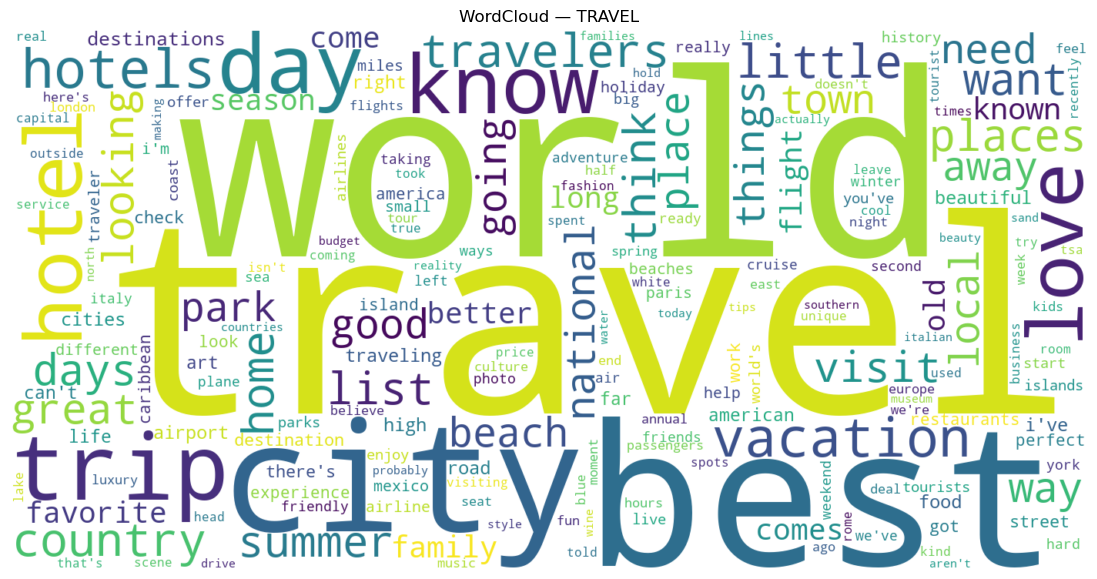

Saved: C:\Users\bbuser\Desktop\news_keyword_baseline\wordcloud_sports.png


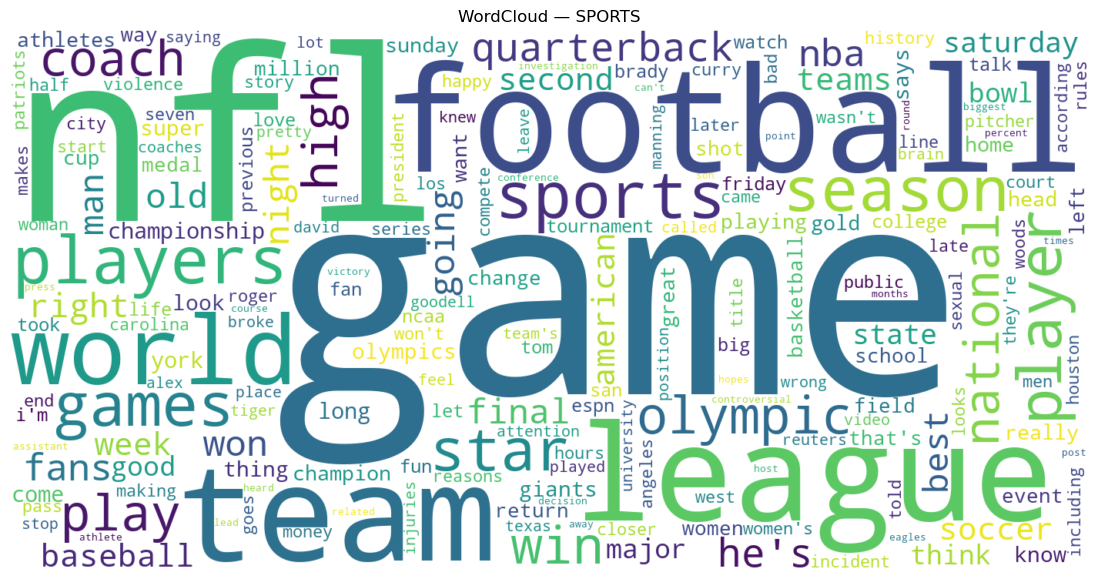

Saved: C:\Users\bbuser\Desktop\news_keyword_baseline\wordcloud_home_and_living.png


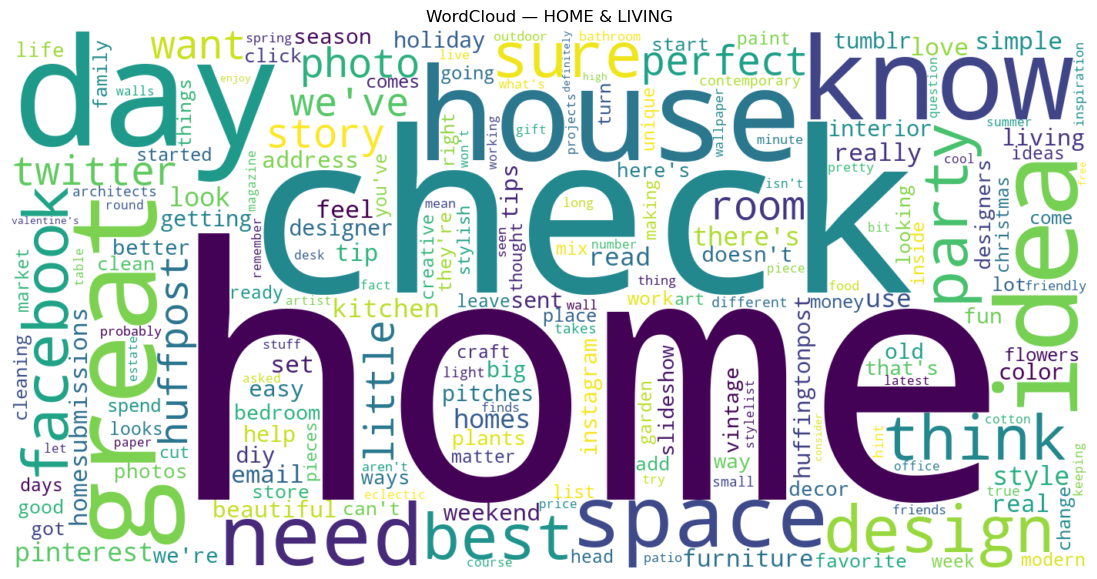

Saved: C:\Users\bbuser\Desktop\news_keyword_baseline\wordcloud_politics.png


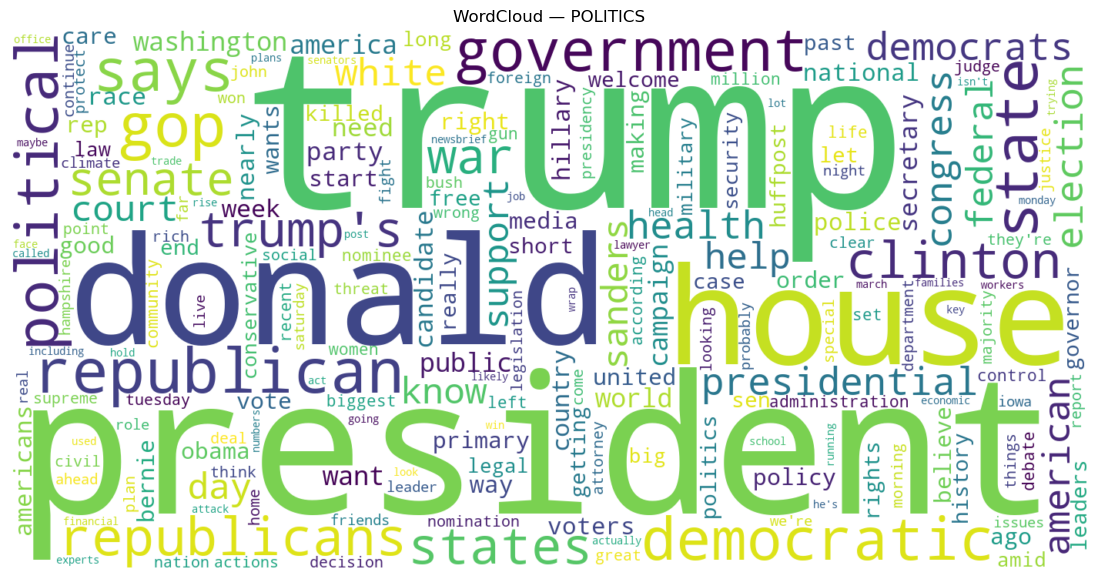

In [12]:
import matplotlib.pyplot as plt

def safe_name(cat: str) -> str:
    return cat.lower().replace("&", "and").replace(" ", "_")

for cat, counter in category_word_freq.items():
    freqs = dict(counter.most_common(200))
    wc = WordCloud(width=1400, height=700, background_color="white")
    wc = wc.generate_from_frequencies(freqs)
    
    out_path = os.path.join(OUTPUT_DIR, f"wordcloud_{safe_name(cat)}.png")
    wc.to_file(out_path)
    print("Saved:", out_path)
    
    plt.figure(figsize=(14,7))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud — {cat}")
    plt.show()

Saved: C:\Users\bbuser\Desktop\news_keyword_baseline\wordcloud_overall.png


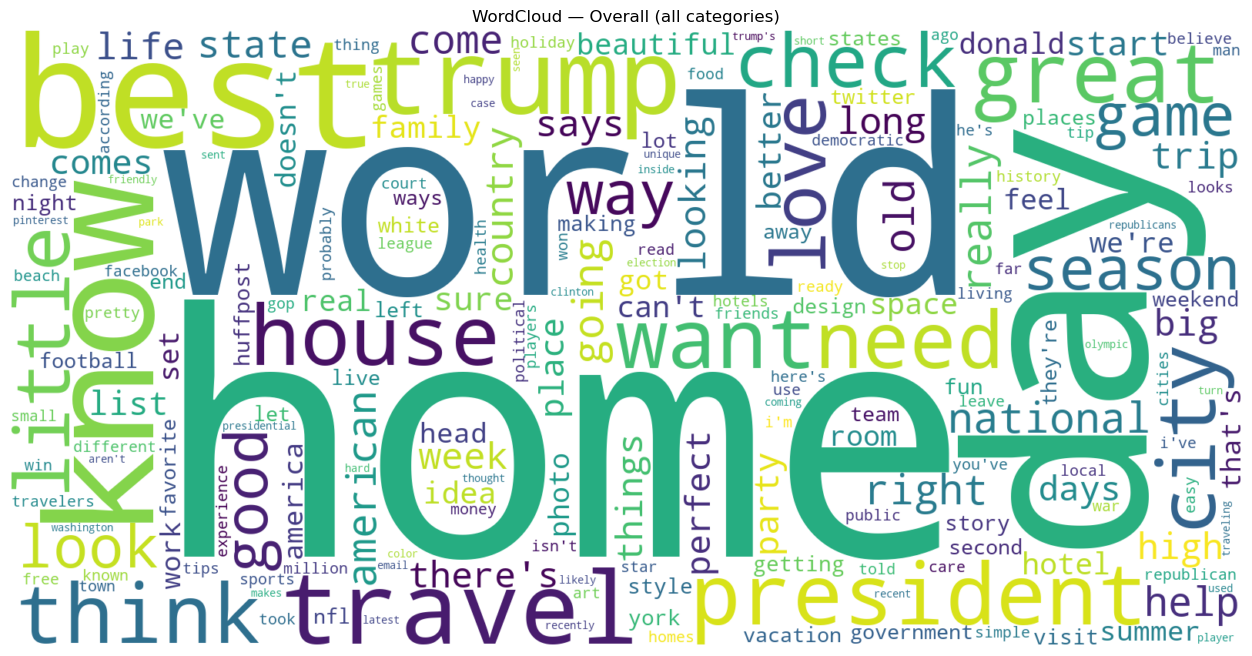

In [13]:
all_counter = Counter()
for c in category_word_freq.values():
    all_counter.update(c)

wc_all = WordCloud(width=1600, height=800, background_color="white")
wc_all = wc_all.generate_from_frequencies(dict(all_counter.most_common(400)))

# Save
overall_path = os.path.join(OUTPUT_DIR, "wordcloud_overall.png")
wc_all.to_file(overall_path)
print("Saved:", overall_path)

# Show inline in Jupyter
plt.figure(figsize=(16,8))
plt.imshow(wc_all, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud — Overall (all categories)")
plt.show()